In [ ]:
import os
import glob
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import welch
import mne
from mne.viz import plot_topomap

BASE_PATH = 'D:/SEM_5/BSP/Gamedeception' 

DATA_DIR = os.path.join(BASE_PATH, 'Preprocessed', 'DecisionMaking')
SUBJECT_FILES = glob.glob(os.path.join(DATA_DIR, 'Player_sub*.mat'))
REPORTS_DIR = os.path.join(BASE_PATH, 'final_meta_analysis_reports')
os.makedirs(REPORTS_DIR, exist_ok=True)

if not SUBJECT_FILES:
    print(f"ERROR: No subject files found in '{DATA_DIR}'. Please check the BASE_PATH variable.")
    exit()

print(f"Found {len(SUBJECT_FILES)} subjects. Final meta-analysis reports will be saved in '{REPORTS_DIR}'")

FREQ_BANDS = {
        'theta': (4, 8), 'alpha': (8, 13),
            'beta': (13, 30), 'gamma': (30, 50)
            }

def extract_band_power_features(data, fs, bands):
    """ Extracts band power features from EEG data (trials, channels, samples). """
    n_trials, n_channels, n_timesteps = data.shape
    features = np.zeros((n_trials, n_channels * len(bands)))
    for trial_idx in range(n_trials):
        for ch_idx in range(n_channels):
            freqs, psd = welch(data[trial_idx, ch_idx, :], fs=fs)
            band_powers = [np.mean(psd[np.logical_and(freqs >= fmin, freqs <= fmax)]) for fmin, fmax in bands.values()]
            features[trial_idx, ch_idx * len(bands):(ch_idx + 1) * len(bands)] = band_powers
            return features
                                

Found 23 subjects. Final meta-analysis reports will be saved in 'D:/SEM_5/BSP/Gamedeception\final_meta_analysis_reports'


In [ ]:

# =============================================================================
# Main Loop: Subject-Specific Training and Aggregation
# =============================================================================
all_subject_accuracies = []
all_feature_importances = []
final_feature_names = []

for subject_file in SUBJECT_FILES:
    subject_name = os.path.basename(subject_file).replace('.mat', '')
    print(f"\n--- Processing Subject: {subject_name} ---")

    try:
        mat_data = scipy.io.loadmat(subject_file, struct_as_record=False, squeeze_me=True)
        player_struct = mat_data['player']

        eeg_epochs_data = np.transpose(player_struct.x, (2, 1, 0)) 
        sampling_rate = int(player_struct.fs)
        channel_names = [str(ch) for ch in player_struct.clab]
        labels_raw = player_struct.y
        class_names = [str(name) for name in player_struct.className]

        lie_indices = {i + 1 for i, name in enumerate(class_names) if 'L' in name.upper()}
        trial_labels = labels_raw[0] if labels_raw.ndim > 1 else labels_raw
        y = np.array([1 if int(lbl) in lie_indices else 0 for lbl in trial_labels], dtype=int)

        if len(np.unique(y)) < 2:
            print(f"  > Skipping: not enough data.")
            continue

        X_features = extract_band_power_features(eeg_epochs_data, sampling_rate, FREQ_BANDS)
        feature_names = [f"{ch}_{band}" for ch in channel_names for band in FREQ_BANDS.keys()]
        if not final_feature_names: 
            final_feature_names = feature_names

        X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.25, random_state=42, stratify=y)
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
        model.fit(X_train, y_train)

        accuracy = model.score(X_test, y_test)
        all_subject_accuracies.append(accuracy)
        all_feature_importances.append(model.feature_importances_)
        print(f"  > Accuracy: {accuracy * 100:.2f}%")

    except Exception as e:
        print(f"  > Could not process. Error: {e}")



--- Processing Subject: Player_sub01_Observer_sub02 ---
  > Accuracy: 70.25%

--- Processing Subject: Player_sub03_Observer_sub06 ---
  > Accuracy: 81.82%

--- Processing Subject: Player_sub04_Observer_sub05 ---
  > Accuracy: 78.51%

--- Processing Subject: Player_sub05_Observer_sub04 ---
  > Accuracy: 80.17%

--- Processing Subject: Player_sub06_Observer_sub03 ---
  > Accuracy: 73.55%

--- Processing Subject: Player_sub07_Observer_sub08 ---
  > Accuracy: 76.86%

--- Processing Subject: Player_sub08_Observer_sub07 ---
  > Accuracy: 80.99%

--- Processing Subject: Player_sub09_Observer_sub10 ---
  > Accuracy: 74.38%

--- Processing Subject: Player_sub10_Observer_sub09 ---
  > Accuracy: 77.69%

--- Processing Subject: Player_sub11_Observer_sub12 ---
  > Accuracy: 81.82%

--- Processing Subject: Player_sub12_Observer_sub11 ---
  > Accuracy: 80.99%

--- Processing Subject: Player_sub13_Observer_sub14 ---
  > Accuracy: 76.03%

--- Processing Subject: Player_sub14_Observer_sub13 ---
  > Acc



--- Overall Performance ---
Average Model Accuracy: 77.51%


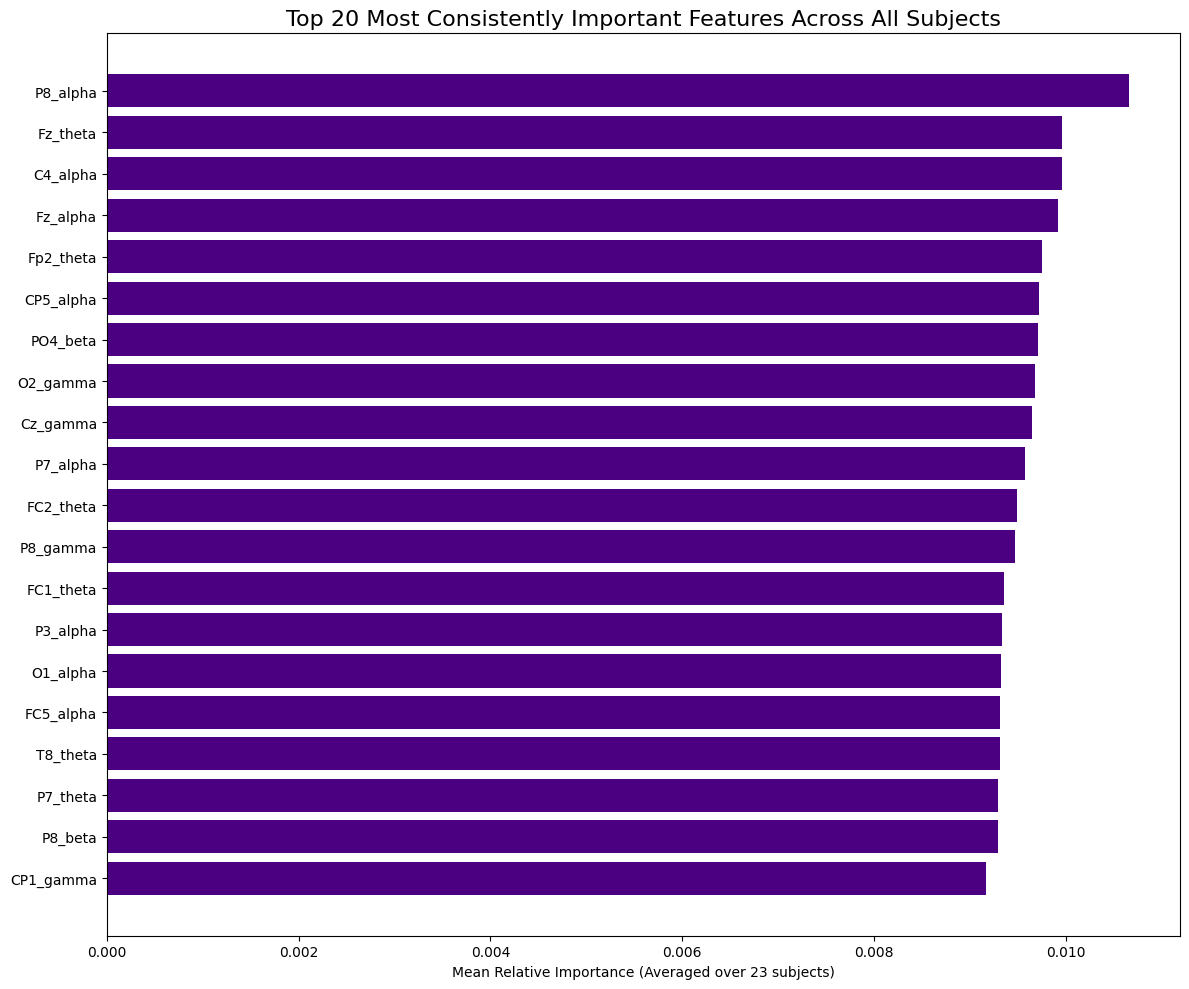

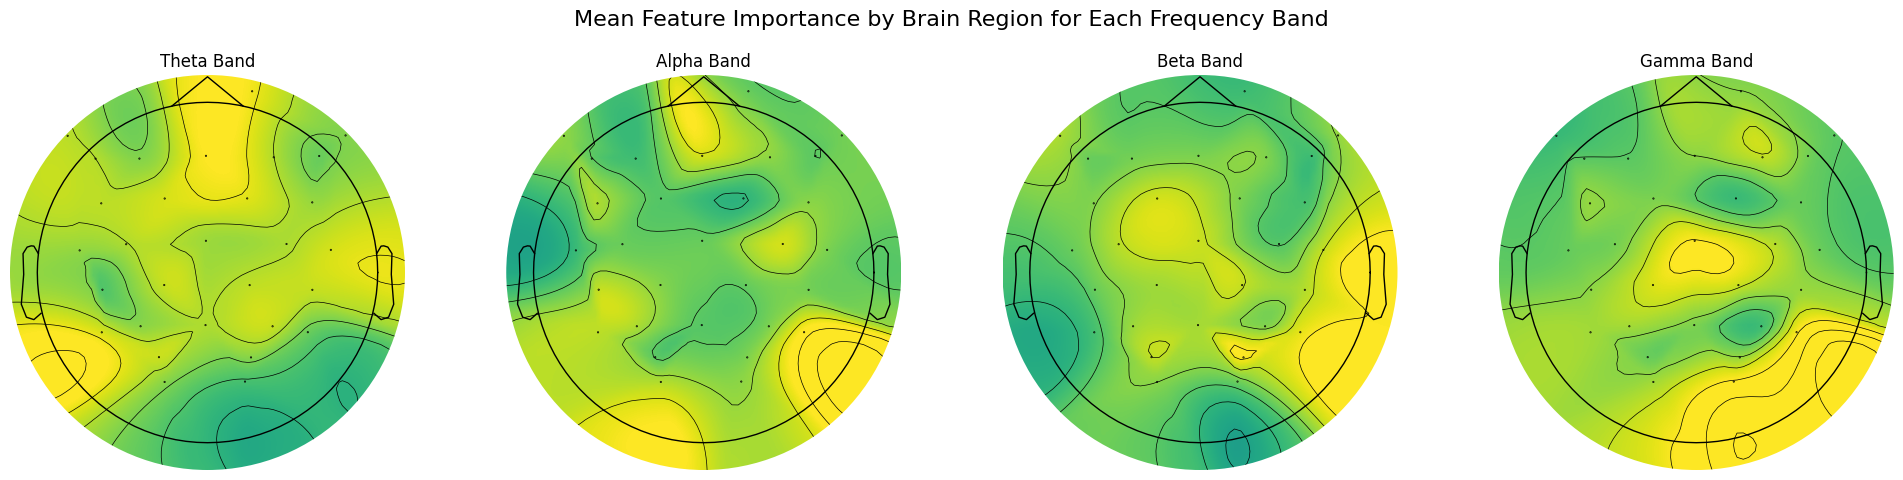

In [ ]:

# =============================================================================
# Final Meta-Analysis and Visualization
# =============================================================================
if all_subject_accuracies:
    mean_accuracy = np.mean(all_subject_accuracies)
    print(f"\n\n--- Overall Performance ---")
    print(f"Average Model Accuracy: {mean_accuracy * 100:.2f}%")
    
    mean_importances = np.mean(all_feature_importances, axis=0)
    indices = np.argsort(mean_importances)[-20:]

    plt.figure(figsize=(12, 10))
    plt.title('Top 20 Most Consistently Important Features Across All Subjects', fontsize=16)
    plt.barh(range(len(indices)), mean_importances[indices], color='indigo', align='center')
    plt.yticks(range(len(indices)), [final_feature_names[i] for i in indices])
    plt.xlabel('Mean Relative Importance (Averaged over 23 subjects)')
    plt.tight_layout()
    plt.savefig(os.path.join(REPORTS_DIR, "meta_analysis_top_20_features.png"))
    plt.show()

    mat_data = scipy.io.loadmat(SUBJECT_FILES[0], struct_as_record=False, squeeze_me=True)
    player_struct = mat_data['player']
    channel_names = [str(ch) for ch in player_struct.clab]
    sampling_rate = int(player_struct.fs)
    info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
    info.set_montage('standard_1005', on_missing='ignore')

    n_channels = len(channel_names)
    n_bands = len(FREQ_BANDS)
    importance_matrix = mean_importances.reshape((n_channels, n_bands))

    fig, axes = plt.subplots(1, n_bands, figsize=(20, 5))
    fig.suptitle('Mean Feature Importance by Brain Region for Each Frequency Band', fontsize=16)
    for i, band_name in enumerate(FREQ_BANDS.keys()):
        ax = axes[i]
        plot_topomap(importance_matrix[:, i], info, axes=ax, show=False, cmap='viridis')
        ax.set_title(f'{band_name.title()} Band')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(REPORTS_DIR, "meta_analysis_topomaps.png"))
    plt.show()
else:
    print("\nNo subjects were successfully processed.")
